# Structuring Worst-of Autocall

## Sommaire :

* [**1.Introduction**](#0)

* [**2.Dynamique Heston + Calibration**](#1)
    * [2.1. Définition de la classe](#1_1)
    * [2.2. Extraction des données + calibration](#1_2)

* [**3. Autocall worst-of**](#2)
    * [3.1. Pricing function](#2_1)
    * [3.2. Sensibilities](#2_2)

<a id='0'></a>
# 1. Introduction :

Ce projet étudie la valorisation d’un produit structuré de type autocallable worst-of reposant sur un panier d’actions. Les sous-jacents sont modélisés à l’aide d’un modèle de Heston multivarié, permettant de prendre en compte à la fois la volatilité stochastique et la dépendance entre actifs, à partir de données de marché. Le prix du produit est estimé par simulation Monte Carlo afin de capturer les mécanismes de rappel anticipé et de protection conditionnelle du capital. Enfin, une analyse de sensibilité met en évidence l’influence des principaux paramètres de marché sur le prix du produit.

In [69]:
# Modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time
from math import log, sqrt, exp, erf
from dataclasses import dataclass, field
from typing import Optional
from typing import Optional, Dict, Any, List, Tuple, Union
import pandas as pd
import numpy as np
import re
from datetime import datetime
import copy

<a id='1'></a>
# 2. Dynamique Heston + Calibration :

On se place sur un espace de probabilité filtré  
$(\Omega,\mathcal{F},(\mathcal{F}_t)_{t\ge 0},\mathbb{Q})$  
sous la mesure risque-neutre $\mathbb{Q}$, avec taux court constant $r$.

---

### Dynamiques Heston multi-actifs (risque-neutre)

Pour $i=1,\dots,d$, l’actif $S^i$ suit une volatilité stochastique $V^i$ :

$$
\frac{dS_t^i}{S_t^i} = r\,dt + \sqrt{V_t^i}\, dW_t^{S,i},
$$

$$
dV_t^i = \kappa_i(\theta_i - V_t^i)\,dt + \xi_i \sqrt{V_t^i}\, dW_t^{V,i},
\qquad V_0^i>0.
$$

Corrélation (structure intra-nom) :

$$
d\langle W^{S,i}, W^{V,i}\rangle_t = \rho_i\,dt,
\qquad \rho_i \in (-1,1).
$$

Corrélation (structure inter-noms) :
on suppose que le vecteur brownien
$$
\bigl(W^{S,1},\dots,W^{S,d},\, W^{V,1},\dots,W^{V,d}\bigr)
$$
a une matrice de corrélation donnée, notée $\Sigma$, i.e.
$$
d\langle W^a, W^b\rangle_t = \Sigma_{ab}\,dt.
$$

<a id='1_1'></a>
## 2.1 Composition de la classe

In [58]:
ArrayLike = Union[float, int, np.ndarray, list]


def _as_1d(x: ArrayLike) -> np.ndarray:
    """Convert scalar/list/array to 1D numpy array."""
    arr = np.array(x, dtype=float)
    if arr.ndim == 0:
        return np.array([float(arr)])
    return arr.astype(float)


def _clip_rho(rho: float) -> float:
    return float(np.clip(rho, -0.999, 0.999))


@dataclass
class HestonParams:
    r: float
    kappa: float
    theta: float
    sigma_v: float
    rho: float
    v0: float
    s0: float


class HestonModel:
    """
    Modèle de Heston (volatilité stochastique), support 1 actif (N=1) ou N actifs.

    Paramètres par actif i:
      - r       : taux sans risque
      - kappa   : vitesse de reversion de la variance
      - theta   : variance long-terme
      - sigma_v : vol-of-vol (xi)
      - rho     : corrélation dW^S / dW^V
      - V0      : variance initiale
      - S0      : spot initial

    Note:
      - La simulation ci-dessous est un Euler simple.
      - Le pricing européen est fait par intégration type Heston (P1/P2) via CF.
      - La calibration est faite avec scipy.optimize.least_squares (robuste, bornes).
    """

    def __init__(
        self,
        r: ArrayLike,
        kappa: ArrayLike,
        theta: ArrayLike,
        sigma_v: ArrayLike,
        rho: ArrayLike,
        V0: ArrayLike,
        S0: ArrayLike,
        corr_matrix_S: Optional[np.ndarray] = None,
    ):
        self.S0 = _as_1d(S0)
        self.V0 = _as_1d(V0)
        self.r = _as_1d(r)
        self.kappa = _as_1d(kappa)
        self.theta = _as_1d(theta)
        self.sigma_v = _as_1d(sigma_v)
        self.rho = _as_1d(rho)

        self.N = int(self.S0.shape[0])
        if not (
            self.V0.shape[0]
            == self.r.shape[0]
            == self.kappa.shape[0]
            == self.theta.shape[0]
            == self.sigma_v.shape[0]
            == self.rho.shape[0]
            == self.N
        ):
            raise ValueError("Tous les paramètres doivent avoir la même taille N (ou être scalaires).")

        # Corrélation entre Brownien prix (S) si multi-actifs
        if self.N > 1:
            if corr_matrix_S is None:
                self.corr_matrix_S = np.eye(self.N)
            else:
                self.corr_matrix_S = np.array(corr_matrix_S, dtype=float)
                if self.corr_matrix_S.shape != (self.N, self.N):
                    raise ValueError("corr_matrix_S doit être de taille (N,N).")
        else:
            self.corr_matrix_S = np.array([[1.0]])

    # ---------------------------------------------------------------------
    # Simulation (Euler)
    # ---------------------------------------------------------------------
    def simulate_paths(
        self,
        T: float,
        n_steps: int,
        n_paths: int,
        seed: Optional[int] = None,
        scheme: str = "full_truncation",
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Simule n_paths trajectoires corrélées (S_t, V_t) sur [0,T] en Heston multi-actifs.

        Retour:
        S_paths: (n_paths, n_steps+1, N)
        V_paths: (n_paths, n_steps+1, N)

        Remarques:
        - Corr(dW^S) = self.corr_matrix_S
        - Corr(dW^{S,i}, dW^{V,i}) = self.rho[i]
        - Corr(dW^{V,i}, dW^{V,j}) = 0 pour i!=j (bloc identité)
        - scheme="full_truncation" recommandé pour garder V >= 0 (plus robuste)
        """
        if seed is not None:
            np.random.seed(seed)

        dt = float(T) / float(n_steps)
        sqdt = np.sqrt(dt)

        N = self.N
        S = np.zeros((n_paths, n_steps + 1, N), dtype=float)
        V = np.zeros((n_paths, n_steps + 1, N), dtype=float)
        S[:, 0, :] = self.S0.reshape(1, N)
        V[:, 0, :] = self.V0.reshape(1, N)

        # Build 2N x 2N correlation matrix
        if N == 1:
            # We'll generate correlated (Z_S, Z_V) directly
            rho = float(self.rho[0])
            for k in range(n_steps):
                Z1 = np.random.randn(n_paths)
                Z2 = np.random.randn(n_paths)
                Z2c = rho * Z1 + np.sqrt(1.0 - rho**2) * Z2

                V_prev = np.maximum(V[:, k, 0], 0.0)
                sqrtV = np.sqrt(V_prev)

                # V update
                V_next = V[:, k, 0] + self.kappa[0] * (self.theta[0] - V[:, k, 0]) * dt + self.sigma_v[0] * sqrtV * sqdt * Z2c
                if scheme == "full_truncation":
                    V_next = np.maximum(V_next, 0.0)
                V[:, k + 1, 0] = V_next

                # S update (Euler on S)
                S[:, k + 1, 0] = S[:, k, 0] + self.r[0] * S[:, k, 0] * dt + sqrtV * S[:, k, 0] * sqdt * Z1

            return S, V

        # N > 1
        corr_full = np.zeros((2 * N, 2 * N), dtype=float)
        corr_full[:N, :N] = self.corr_matrix_S
        corr_full[N:, N:] = np.eye(N)

        R = np.diag(self.rho.flatten())
        corr_full[:N, N:] = R
        corr_full[N:, :N] = R

        # Cholesky
        L = np.linalg.cholesky(corr_full)

        r = self.r.reshape(1, N)
        kappa = self.kappa.reshape(1, N)
        theta = self.theta.reshape(1, N)
        sigma_v = self.sigma_v.reshape(1, N)

        for k in range(n_steps):
            # Generate correlated Gaussian shocks for all paths at once
            Z = np.random.randn(n_paths, 2 * N)
            X = Z @ L.T  # (n_paths, 2N)

            ZS = X[:, :N]   # shocks for price BMs
            ZV = X[:, N:]   # shocks for variance BMs

            V_prev = np.maximum(V[:, k, :], 0.0)
            sqrtV = np.sqrt(V_prev)

            # Variance update
            V_next = V[:, k, :] + (kappa * (theta - V[:, k, :])) * dt + (sigma_v * sqrtV) * sqdt * ZV
            if scheme == "full_truncation":
                V_next = np.maximum(V_next, 0.0)
            V[:, k + 1, :] = V_next

            # Spot update
            S[:, k + 1, :] = S[:, k, :] + (r * S[:, k, :]) * dt + (sqrtV * S[:, k, :]) * sqdt * ZS

        return S, V

    # ---------------------------------------------------------------------
    # Characteristic function (log S_T)
    # ---------------------------------------------------------------------
    def char_function(self, u: np.ndarray, t: float, asset_index: int = 0) -> np.ndarray:
        """
        Fonction caractéristique de ln(S_t):
          phi(u) = E[ exp(i u ln S_t) ]
        """
        i = int(asset_index) if self.N > 1 else 0

        kappa = float(self.kappa[i])
        theta = float(self.theta[i])
        sigma = float(self.sigma_v[i])
        rho = float(self.rho[i])
        v0 = float(self.V0[i])
        s0 = float(self.S0[i])
        r = float(self.r[i])

        u = np.asarray(u, dtype=np.complex128)

        gamma = kappa - 1j * rho * sigma * u
        d = np.sqrt(gamma**2 + (sigma**2) * (u**2 + 1j * u))
        g = (gamma - d) / (gamma + d)

        e_dt = np.exp(-d * t)
        G = (1 - g * e_dt) / (1 - g)

        C = (kappa * theta / (sigma**2)) * ((gamma - d) * t - 2.0 * np.log(G))
        D = ((gamma - d) / (sigma**2)) * ((1 - e_dt) / (1 - g * e_dt))

        return np.exp(C + D * v0 + 1j * u * (np.log(s0) + r * t))

    # ---------------------------------------------------------------------
    # European call pricing (Heston P1/P2)
    # ---------------------------------------------------------------------
    def _prob_P(self, K: float, T: float, j: int, asset_index: int = 0,
                U_max: float = 150.0, n: int = 4000) -> float:
        """
        Compute P1 or P2 in Heston:
          C = S0 * P1 - K e^{-rT} * P2
        Using standard Fourier integrals.
        """
        i = int(asset_index) if self.N > 1 else 0
        r = float(self.r[i])

        k = np.log(K)

        u = np.linspace(1e-8, U_max, n)  # avoid zero
        u = u.astype(np.complex128)

        if j == 1:
            # phi(u - i) / (phi(-i)) trick for stability
            phi_num = self.char_function(u - 1j, t=T, asset_index=i)
            phi_den = self.char_function(-1j, t=T, asset_index=i)
            phi = phi_num / phi_den
        elif j == 2:
            phi = self.char_function(u, t=T, asset_index=i)
        else:
            raise ValueError("j must be 1 or 2")

        integrand = np.exp(-1j * u * k) * phi / (1j * u)
        val = 0.5 + (1.0 / np.pi) * np.trapz(np.real(integrand), np.real(u))
        return float(val)

    def price_option(
        self,
        K: float,
        T: float,
        option_type: str = "call",
        asset_index: int = 0,
        U_max: float = 150.0,
        n_integration: int = 4000,
    ) -> float:
        """
        Prix européen call/put via Heston:
          Call: C = S0 P1 - K e^{-rT} P2
          Put : parity
        """
        i = int(asset_index) if self.N > 1 else 0
        s0 = float(self.S0[i])
        r = float(self.r[i])

        P1 = self._prob_P(K, T, j=1, asset_index=i, U_max=U_max, n=n_integration)
        P2 = self._prob_P(K, T, j=2, asset_index=i, U_max=U_max, n=n_integration)

        call = s0 * P1 - K * np.exp(-r * T) * P2

        if option_type.lower() == "call":
            return float(call)
        if option_type.lower() == "put":
            return float(call - s0 + K * np.exp(-r * T))
        raise ValueError("option_type must be 'call' or 'put'")

    # ---------------------------------------------------------------------
    # Calibration (robuste) - least squares with bounds
    # ---------------------------------------------------------------------
    def calibrate(
        self,
        strikes: np.ndarray,
        maturities: np.ndarray,
        market_prices: np.ndarray,
        asset_index: int = 0,
        initial_guess: Optional[Tuple[float, float, float, float, float]] = None,
        bounds: Optional[Tuple[Tuple[float, float, float, float, float],
                              Tuple[float, float, float, float, float]]] = None,
        weights: Optional[np.ndarray] = None,
        U_max: float = 150.0,
        n_integration: int = 2500,
        max_nfev: int = 80,
    ):
        """
        Calibre (kappa, theta, sigma_v, rho, v0) sur prix (calls) par moindres carrés.

        - Utilise scipy.optimize.least_squares (TRF) + bornes.
        - weights optionnel (par ex 1/price) pour stabiliser.

        Retour:
          params_opt (kappa, theta, sigma_v, rho, v0), result_scipy
        """
        from scipy.optimize import least_squares

        i = int(asset_index) if self.N > 1 else 0

        K = np.asarray(strikes, dtype=float).ravel()
        T = np.asarray(maturities, dtype=float).ravel()
        C_mkt = np.asarray(market_prices, dtype=float).ravel()

        if not (len(K) == len(T) == len(C_mkt)):
            raise ValueError("strikes, maturities, market_prices must have same length (flat lists).")

        if weights is None:
            weights = 1.0 / np.maximum(C_mkt, 1e-3)
        else:
            weights = np.asarray(weights, dtype=float).ravel()
            if len(weights) != len(C_mkt):
                raise ValueError("weights must have same length as market_prices")

        if initial_guess is None:
            x0 = np.array([
                float(self.kappa[i]),
                float(self.theta[i]),
                float(self.sigma_v[i]),
                float(self.rho[i]),
                float(self.V0[i]),
            ], dtype=float)
        else:
            x0 = np.array(initial_guess, dtype=float)

        if bounds is None:
            lb = np.array([1e-3, 1e-8, 1e-3, -0.999, 1e-8], dtype=float)
            ub = np.array([50.0, 5.0,  10.0,  0.999, 5.0], dtype=float)
        else:
            lb = np.array(bounds[0], dtype=float)
            ub = np.array(bounds[1], dtype=float)

        def _set_params(x):
            self.kappa[i] = float(x[0])
            self.theta[i] = float(x[1])
            self.sigma_v[i] = float(x[2])
            self.rho[i] = _clip_rho(float(x[3]))
            self.V0[i] = float(max(x[4], 0.0))

        def residuals(x):
            # enforce constraints softly via bounds (handled by least_squares)
            _set_params(x)

            # model prices (loop; ok for calibration subset)
            C_model = np.empty_like(C_mkt)
            for npt in range(len(C_mkt)):
                C_model[npt] = self.price_option(
                    K=float(K[npt]),
                    T=float(T[npt]),
                    option_type="call",
                    asset_index=i,
                    U_max=U_max,
                    n_integration=n_integration
                )
            return weights * (C_model - C_mkt)

        res = least_squares(
            residuals,
            x0,
            bounds=(lb, ub),
            method="trf",
            ftol=1e-6, xtol=1e-6, gtol=1e-6,
            max_nfev=max_nfev,
        )

        _set_params(res.x)

        params_opt = (float(self.kappa[i]), float(self.theta[i]), float(self.sigma_v[i]), float(self.rho[i]), float(self.V0[i]))
        return params_opt, res

<a id='1_2'></a>
## 1.2 Extraction et calibration

In [59]:
# =========================
# CONFIG
# =========================
PATH_XLSX = "/Users/quentinsenes/Desktop/Produits structurés/CalibrationData.xlsx"
TODAY = datetime(2025, 12, 15)

SHEETS = ["LVMH", "BNP", "AirBus", "Axa", "L'oreal", "Total"]


# =========================
# DATE PARSERS
# =========================
def parse_date_dd_Mmm_yy(s: str):
    # Example: "19-Dec-25 (4d); ..."  -> 19-Dec-25
    m = re.search(r"\b(\d{1,2}-[A-Za-z]{3}-\d{2})\b", s)
    if not m:
        return None
    return datetime.strptime(m.group(1), "%d-%b-%y")


def parse_date_mm_dd_yy(s: str):
    # Example: "EA1 12/19/25" -> 12/19/25
    m = re.search(r"\b(\d{1,2}/\d{1,2}/\d{2})\b", s)
    if not m:
        return None
    return datetime.strptime(m.group(1), "%m/%d/%y")


def yearfrac(expiry: datetime, today: datetime = TODAY) -> float:
    return (expiry - today).days / 365.0


# =========================
# TABLE EXTRACTORS
# =========================
def extract_left_table(df_raw: pd.DataFrame, sheet_name: str) -> pd.DataFrame:
    """
    Left table = columns A..G:
      Strike | Ticker | Bid | Ask | Last | IVM | Volm

    Maturity header rows are in Strike, like:
      "19-Dec-25 (4d); CSize 102; R 2.14; IFwd 195.87"
    """
    if df_raw.shape[1] < 7:
        return pd.DataFrame()

    t = df_raw.iloc[:, 0:7].copy()
    t.columns = ["Strike", "Ticker", "Bid", "Ask", "Last", "IVM", "Volm"]

    # Identify maturity header rows (Strike contains dd-Mmm-yy)
    strike_str = t["Strike"].astype(str)
    is_header = strike_str.str.contains(r"\d{1,2}-[A-Za-z]{3}-\d{2}", na=False, regex=True)

    # Create a T column: parse T on header rows then forward-fill
    T = np.full(len(t), np.nan, dtype=float)

    header_idx = t.index[is_header].to_list()
    for idx in header_idx:
        s = str(t.loc[idx, "Strike"])
        d = parse_date_dd_Mmm_yy(s)
        if d is None:
            continue
        T[t.index.get_loc(idx)] = yearfrac(d, TODAY)

    # forward fill T
    T_series = pd.Series(T, index=t.index).ffill()
    t["T"] = T_series

    # Keep only numeric strikes (option rows)
    t["K"] = pd.to_numeric(t["Strike"], errors="coerce")
    t["Bid"] = pd.to_numeric(t["Bid"], errors="coerce")
    t["Ask"] = pd.to_numeric(t["Ask"], errors="coerce")
    t["IV"]  = pd.to_numeric(t["IVM"], errors="coerce")  # IVM column is IV in your file

    t["Mid"] = 0.5 * (t["Bid"] + t["Ask"])

    out = t.dropna(subset=["K", "T", "Bid", "Ask", "IV", "Mid"]).copy()
    out = out[(out["K"] > 0) & (out["Mid"] > 0) & (out["IV"] > 0) & (out["T"] > 0)]

    out = out[["K", "T", "Mid", "IV"]].copy()
    out.insert(0, "Name", sheet_name)
    out["Side"] = "left"
    return out.reset_index(drop=True)


def extract_right_table(df_raw: pd.DataFrame, sheet_name: str) -> pd.DataFrame:
    """
    Right table = columns H..N:
      Strike | Ticker | Bid | Ask | Last | IVM | Volm

    Here maturity is embedded per-row in Ticker like "EA1 12/19/25".
    """
    if df_raw.shape[1] < 14:
        return pd.DataFrame()

    t = df_raw.iloc[:, 7:14].copy()
    t.columns = ["Strike", "Ticker", "Bid", "Ask", "Last", "IVM", "Volm"]

    # Parse T from Ticker for each row
    def parse_T_from_ticker(x):
        if pd.isna(x):
            return np.nan
        d = parse_date_mm_dd_yy(str(x))
        if d is None:
            return np.nan
        return yearfrac(d, TODAY)

    t["T"] = t["Ticker"].apply(parse_T_from_ticker)

    t["K"] = pd.to_numeric(t["Strike"], errors="coerce")
    t["Bid"] = pd.to_numeric(t["Bid"], errors="coerce")
    t["Ask"] = pd.to_numeric(t["Ask"], errors="coerce")
    t["IV"]  = pd.to_numeric(t["IVM"], errors="coerce")

    t["Mid"] = 0.5 * (t["Bid"] + t["Ask"])

    out = t.dropna(subset=["K", "T", "Bid", "Ask", "IV", "Mid"]).copy()
    out = out[(out["K"] > 0) & (out["Mid"] > 0) & (out["IV"] > 0) & (out["T"] > 0)]

    out = out[["K", "T", "Mid", "IV"]].copy()
    out.insert(0, "Name", sheet_name)
    out["Side"] = "right"
    return out.reset_index(drop=True)


def get_sheet_market_data(xls: pd.ExcelFile, sheet_name: str) -> pd.DataFrame:
    df_raw = xls.parse(sheet_name, header=None)  # keep raw layout
    left = extract_left_table(df_raw, sheet_name)
    right = extract_right_table(df_raw, sheet_name)

    out = pd.concat([left, right], ignore_index=True)
    # sort nicely
    if len(out) > 0:
        out = out.sort_values(["Name", "T", "K", "Side"]).reset_index(drop=True)
    return out


def load_all(path_xlsx: str, sheets: list[str]) -> pd.DataFrame:
    xls = pd.ExcelFile(path_xlsx)
    dfs = []
    for s in sheets:
        df_s = get_sheet_market_data(xls, s)
        print(f"{s}: rows={len(df_s)}")
        dfs.append(df_s)

    out = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    print("Rows total:", len(out))
    return out


# =========================
# RUN
# =========================
if __name__ == "__main__":
    market_df = load_all(PATH_XLSX, SHEETS)

    print(market_df.head(20))
    if len(market_df) > 0:
        print("\nRows per Name:")
        print(market_df.groupby("Name").size())
        print("\nMaturity range (years):", market_df["T"].min(), "->", market_df["T"].max())

LVMH: rows=130
BNP: rows=100
AirBus: rows=113
Axa: rows=95
L'oreal: rows=150
Total: rows=98
Rows total: 686
    Name      K         T        Mid         IV   Side
0   LVMH  610.0  0.010959  18.829994  26.845966   left
1   LVMH  610.0  0.010959  18.784996  27.230528   left
2   LVMH  610.0  0.010959  18.690002  27.030376   left
3   LVMH  610.0  0.010959   2.750000  27.014153  right
4   LVMH  610.0  0.010959   2.750000  27.014153  right
5   LVMH  610.0  0.010959   2.750000  27.009617  right
6   LVMH  620.0  0.010959  11.345000  26.217348   left
7   LVMH  620.0  0.010959  11.550000  26.250319   left
8   LVMH  620.0  0.010959  11.585000  26.052414   left
9   LVMH  620.0  0.010959   5.595000  26.175716  right
10  LVMH  620.0  0.010959   5.595000  26.046724  right
11  LVMH  620.0  0.010959   5.595000  26.175657  right
12  LVMH  630.0  0.010959   6.380000  26.153337   left
13  LVMH  630.0  0.010959   6.380000  26.288420   left
14  LVMH  630.0  0.010959   6.380000  26.137066   left
15  LVMH  63

In [60]:
# =========================
# Subset calibration set
# =========================

def build_calibration_subset(market_df, name, max_maturities=6, n_strikes_per_T=10):
    df = market_df[market_df["Name"] == name].copy()
    df = df.dropna(subset=["K", "T", "Mid", "Side"])

    # keep only sensible rows
    df = df[(df["K"] > 0) & (df["T"] > 0) & (df["Mid"] > 0)]

    # OPTIONAL (recommended): de-duplicate repeated quotes at same (K,T,Side)
    # If you prefer to keep all quotes, comment out the groupby
    df = (
        df.groupby(["Name", "K", "T", "Side"], as_index=False)
          .agg({"Mid": "mean", "IV": "mean"})
    )

    df = df.sort_values(["T", "K"])

    Ts = np.sort(df["T"].unique())[:max_maturities]

    blocks = []
    for T in Ts:
        dT = df[df["T"] == T].copy()
        if len(dT) == 0:
            continue

        # pick around median strike (proxy ATM region)
        K0 = float(np.median(dT["K"].values))
        dT["dist"] = np.abs(dT["K"] - K0)
        dT = dT.sort_values("dist").head(n_strikes_per_T)

        blocks.append(dT)

    out = pd.concat(blocks, ignore_index=True).sort_values(["T", "K"]).reset_index(drop=True)
    return out


def proxy_S0_from_data(calib_df):
    Tmin = float(calib_df["T"].min())
    return float(np.median(calib_df[calib_df["T"] == Tmin]["K"].values))


def _row_option_type(side):
    side = str(side).lower()
    if side == "right":
        return "call"
    elif side == "left":
        return "put"
    else:
        raise ValueError(f"Side inconnu: {side} (attendu 'left'/'right')")


# =========================
# Calibrate one underlying
# =========================
def calibrate_one(
    market_df,
    name,
    r=0.02,
    init=(2.0, 0.25**2, 0.7, -0.5, 0.25**2),   # (kappa, theta, sigma_v, rho, v0)
    subset=(6, 10),                            # (max_maturities, n_strikes_per_T)
    U_max=120.0,
    n_integration=2000,
    max_nfev=60,
    rho_bounds=(-0.95, -0.05),                 # <-- force rho to stay negative
):
    max_maturities, n_strikes_per_T = subset

    calib_df = build_calibration_subset(
        market_df, name,
        max_maturities=max_maturities,
        n_strikes_per_T=n_strikes_per_T
    )
    if len(calib_df) < 10:
        raise ValueError(f"[{name}] Pas assez de points pour calibrer (n={len(calib_df)}).")

    S0 = proxy_S0_from_data(calib_df)

    # init model (N=1)
    kappa0, theta0, sigma_v0, rho0, v00 = init
    model = HestonModel(r=r, kappa=kappa0, theta=theta0, sigma_v=sigma_v0, rho=rho0, V0=v00, S0=S0)

    K = calib_df["K"].values.astype(float)
    T = calib_df["T"].values.astype(float)
    Mid = calib_df["Mid"].values.astype(float)
    Side = calib_df["Side"].values

    # ---- enforce bounds (rho forced negative)
    lb = np.array((1e-3, 1e-8, 1e-3, float(rho_bounds[0]), 1e-8), dtype=float)
    ub = np.array((50.0, 5.0, 10.0, float(rho_bounds[1]), 5.0), dtype=float)

    rho0_clipped = float(np.clip(rho0, lb[3], ub[3]))
    x0 = np.array([kappa0, theta0, sigma_v0, rho0_clipped, v00], dtype=float)
    x0 = np.minimum(np.maximum(x0, lb), ub)

    # =========================
    # Objective (price RMSE / SSE) using Side -> call/put
    # =========================
    def objective(params):
        kappa, theta, sigma_v, rho, v0 = params

        # hard constraints
        if np.any(params < lb) or np.any(params > ub):
            return 1e99

        # update model
        model.kappa[0] = float(kappa)
        model.theta[0] = float(theta)
        model.sigma_v[0] = float(sigma_v)
        model.rho[0] = float(rho)
        model.V0[0] = float(v0)

        err2 = 0.0
        for k, t, m, s in zip(K, T, Mid, Side):
            opt_type = _row_option_type(s)
            # keep your signature; if your price_option accepts U_max/n_integration, pass them
            p = model.price_option(float(k), float(t), option_type=opt_type, asset_index=0)
            d = (p - m)
            err2 += d * d
        return err2

    # =========================
    # Simple bounded random search (no SciPy)
    # =========================
    best_x = x0.copy()
    best_f = objective(best_x)

    rng = np.random.default_rng(123)

    for _ in range(int(max_nfev)):
        cand = best_x.copy()

        # multiplicative steps for positive params
        cand[0] *= np.exp(0.30 * rng.normal())   # kappa
        cand[1] *= np.exp(0.50 * rng.normal())   # theta
        cand[2] *= np.exp(0.50 * rng.normal())   # sigma_v
        cand[4] *= np.exp(0.50 * rng.normal())   # v0

        # additive step for rho
        cand[3] += 0.10 * rng.normal()

        # clip to bounds
        cand = np.minimum(np.maximum(cand, lb), ub)

        f = objective(cand)
        if f < best_f:
            best_f = f
            best_x = cand

    # set best params
    model.kappa[0], model.theta[0], model.sigma_v[0], model.rho[0], model.V0[0] = best_x.tolist()

    # diagnostics: fitted prices
    C_fit = np.array([
        model.price_option(float(k), float(t), option_type=_row_option_type(s), asset_index=0)
        for k, t, s in zip(K, T, Side)
    ])
    rmse = float(np.sqrt(np.mean((C_fit - Mid) ** 2)))

    result = {
        "Name": name,
        "n_points": len(calib_df),
        "S0_proxy": float(model.S0[0]),
        "r": float(r),
        "kappa": float(model.kappa[0]),
        "theta": float(model.theta[0]),
        "sigma_v": float(model.sigma_v[0]),
        "rho": float(model.rho[0]),
        "v0": float(model.V0[0]),
        "rmse_price": rmse,
        "success": True,
        "nfev": int(max_nfev),
        "cost": float(best_f),
    }

    fit_table = calib_df[["K", "T", "Mid", "Side"]].copy()
    fit_table["Model"] = C_fit
    fit_table["Error"] = fit_table["Model"] - fit_table["Mid"]
    fit_table["Name"] = name

    return model, result, fit_table


# =========================
# Calibrate many underlyings
# =========================
def calibrate_many(
    market_df,
    names,
    r=0.02,
    init=(2.0, 0.25**2, 0.7, -0.5, 0.25**2),
    subset=(6, 10),
    U_max=120.0,
    n_integration=2000,
    max_nfev=60,
    rho_bounds=(-0.95, -0.05),   # <-- force rho negative for all assets
):
    models = {}
    results = []
    all_fit = []

    for name in names:
        print(f"\n--- Calibrating {name} ---")
        model, res_row, fit_table = calibrate_one(
            market_df=market_df,
            name=name,
            r=r,
            init=init,
            subset=subset,
            U_max=U_max,
            n_integration=n_integration,
            max_nfev=max_nfev,
            rho_bounds=rho_bounds,
        )
        models[name] = model
        results.append(res_row)
        all_fit.append(fit_table)

        print(
            f"{name}: rmse={res_row['rmse_price']:.6f}, "
            f"kappa={res_row['kappa']:.4f}, theta={res_row['theta']:.6f}, "
            f"sigma_v={res_row['sigma_v']:.4f}, rho={res_row['rho']:.4f}, v0={res_row['v0']:.6f} "
            f"(n={res_row['n_points']}, nfev={res_row['nfev']}, success={res_row['success']})"
        )

    results_df = pd.DataFrame(results).sort_values("rmse_price").reset_index(drop=True)
    fit_df = pd.concat(all_fit, ignore_index=True) if all_fit else pd.DataFrame()
    return models, results_df, fit_df


# =========================
# RUN
# =========================
NAMES_6 = ["LVMH", "BNP", "AirBus", "Axa", "L'oreal", "Total"]

models, results_df, fit_df = calibrate_many(
    market_df=market_df,
    names=NAMES_6,
    r=0.02,
    rho_bounds=(-0.95, -0.05)
)

print(results_df)
fit_df.to_csv("heston_fit_debug.csv", index=False)



--- Calibrating LVMH ---
LVMH: rmse=34.616989, kappa=2.1155, theta=0.097818, sigma_v=0.0731, rho=-0.0989, v0=0.107731 (n=54, nfev=60, success=True)

--- Calibrating BNP ---
BNP: rmse=4.544052, kappa=1.7194, theta=0.187972, sigma_v=0.0879, rho=-0.0500, v0=0.057134 (n=45, nfev=60, success=True)

--- Calibrating AirBus ---
AirBus: rmse=9.102138, kappa=3.8371, theta=0.095710, sigma_v=0.0692, rho=-0.2244, v0=0.079587 (n=53, nfev=60, success=True)

--- Calibrating Axa ---
Axa: rmse=2.071445, kappa=3.1938, theta=0.071142, sigma_v=0.0356, rho=-0.3072, v0=0.025130 (n=48, nfev=60, success=True)

--- Calibrating L'oreal ---
L'oreal: rmse=20.403084, kappa=2.4121, theta=0.082719, sigma_v=0.1601, rho=-0.0500, v0=0.056445 (n=51, nfev=60, success=True)

--- Calibrating Total ---
Total: rmse=1.845309, kappa=6.3566, theta=0.032311, sigma_v=0.2530, rho=-0.0500, v0=0.112967 (n=33, nfev=60, success=True)
      Name  n_points  S0_proxy     r     kappa     theta   sigma_v       rho  \
0    Total        33  

In [61]:
names = ["L'oreal", "LVMH", "AirBus", "Total", "BNP", "Axa"]  

# --- corr matrix ---
corr_matrix_S = np.array([
    [1.000, 0.557, 0.255, 0.161, 0.299, 0.236],
    [0.557, 1.000, 0.255, 0.313, 0.251, 0.279],
    [0.255, 0.255, 1.000, 0.293, 0.462, 0.423],
    [0.161, 0.313, 0.293, 1.000, 0.384, 0.364],
    [0.299, 0.251, 0.462, 0.384, 1.000, 0.589],
    [0.236, 0.279, 0.423, 0.364, 0.589, 1.000],
], dtype=float)


# --- paramètres calibrés : remplis depuis results_df ---
param = {row["Name"]: row for _, row in results_df.iterrows()}

S0 = np.array([param[n]["S0_proxy"] for n in names], dtype=float)
V0 = np.array([param[n]["v0"] for n in names], dtype=float)
r  = np.array([param[n]["r"] for n in names], dtype=float)

kappa   = np.array([param[n]["kappa"] for n in names], dtype=float)
theta   = np.array([param[n]["theta"] for n in names], dtype=float)
sigma_v = np.array([param[n]["sigma_v"] for n in names], dtype=float)
rho     = np.array([param[n]["rho"] for n in names], dtype=float)

# --- crée le modèle multi-actifs ---
model_multi = HestonModel(
    r=r, kappa=kappa, theta=theta, sigma_v=sigma_v, rho=rho, V0=V0, S0=S0,
    corr_matrix_S=corr_matrix_S
)

# --- simule des trajectoires corrélées ---
T = 1.0
n_steps = 252
n_paths = 20000

S_paths, V_paths = model_multi.simulate_paths(T=T, n_steps=n_steps, n_paths=n_paths, seed=123)

print(S_paths.shape)  # (n_paths, n_steps+1, 5)
print(V_paths.shape)

(20000, 253, 6)
(20000, 253, 6)


In [62]:
# ===================================
# Rapide check de la correl empirique
# ===================================

# log-returns
log_ret = np.log(S_paths[:, 1:, :] / S_paths[:, :-1, :])

# stack paths & time
R = log_ret.reshape(-1, log_ret.shape[2])

# empirical correlation
corr_emp = np.corrcoef(R.T)

print("Empirical correlation (1-step log-returns):")
print(np.round(corr_emp, 3))

Empirical correlation (1-step log-returns):
[[1.    0.552 0.253 0.153 0.295 0.233]
 [0.552 1.    0.255 0.303 0.248 0.276]
 [0.253 0.255 1.    0.282 0.458 0.421]
 [0.153 0.303 0.282 1.    0.359 0.342]
 [0.295 0.248 0.458 0.359 1.    0.587]
 [0.233 0.276 0.421 0.342 0.587 1.   ]]


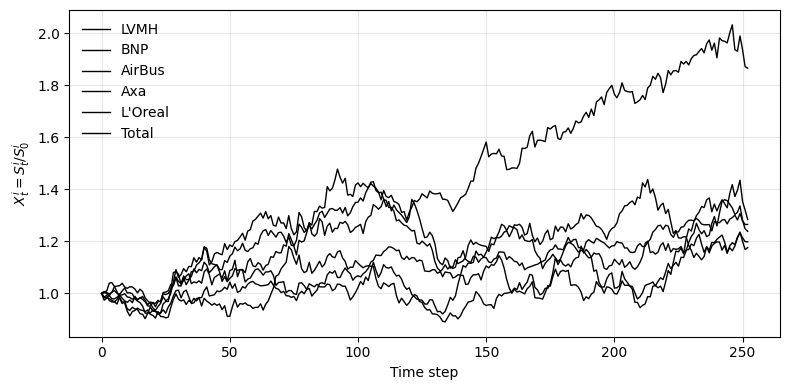

In [63]:
# ==============
# Graphe rapport
# ==============

def plot_normalized_paths_bw(S_paths, names, path_index=0):
    """
    Plot one normalized path per asset:
    X_t^i = S_t^i / S_0^i
    """
    n_steps_plus_1 = S_paths.shape[1]
    t = np.arange(n_steps_plus_1)

    plt.figure(figsize=(8, 4))

    for i, name in enumerate(names):
        S0 = S_paths[path_index, 0, i]
        X = S_paths[path_index, :, i] / S0
        plt.plot(t, X, color="black", linewidth=1, label=name)

    plt.xlabel("Time step")
    plt.ylabel(r"$X_t^i = S_t^i / S_0^i$")
    #plt.title("Normalized correlated Heston paths")
    plt.legend(frameon=False)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.savefig("/Users/quentinsenes/Desktop/path.png", dpi=300, bbox_inches="tight")
    plt.show()


# =======
# USAGE
# =======
names = ["LVMH", "BNP", "AirBus", "Axa", "L'Oreal", "Total"]

plot_normalized_paths_bw(S_paths, names, path_index=0)


<a id='2'></a>
# 3. Autocall worst-of :

### Worst-of autocall (payoff) et estimateur Monte Carlo

On travaille avec les sous-jacents normalisés
$$
X_t^i = \frac{S_t^i}{S_0^i},\qquad i=1,\dots,d,
$$
et le *worst-of*
$$
W_t = \min_{1\le i\le d} X_t^i.
$$

Soient des dates d’observation
$$
0<t_1<\cdots<t_N=T,
$$
une barrière constante $B>0$, un coupon constant $C>0$, un nominal $N_0>0$ et un taux sans risque constant $r$.

**Règle d'autocall.** On définit l’indice de première date de rappel
$$
\kappa=\inf\{k\in\{1,\dots,N\}: W_{t_k}\ge B\},
\qquad \inf(\varnothing)=+\infty,
$$
et le temps de paiement
$$
\tau=\begin{cases}
t_\kappa, & \text{si }\kappa<+\infty,\\
T, & \text{sinon}.
\end{cases}
$$

**Payoff.** Sur une trajectoire, le payoff (non actualisé) vaut
$$
\Pi=
\begin{cases}
N_0(1+C), & \text{si }\kappa<+\infty,\\[4pt]
N_0(1+C), & \text{si }\kappa=+\infty\ \text{et}\ W_T\ge B,\\[4pt]
N_0\,W_T, & \text{si }\kappa=+\infty\ \text{et}\ W_T<B.
\end{cases}
$$

**Valeur (pricing) sous la mesure de pricing $\mathbb{Q}^\star$.**
$$
V_0=\mathbb{E}^{\mathbb{Q}^\star}\!\left[e^{-r\tau}\Pi\right].
$$

**Estimateur Monte Carlo.** En simulant $M$ trajectoires i.i.d. et en notant $(\tau^{(m)},\Pi^{(m)})$ les quantités associées à la trajectoire $m$,
$$
\widehat V_0
=
\frac{1}{M}\sum_{m=1}^M e^{-r\tau^{(m)}}\,\Pi^{(m)}.
$$


<a id='2_1'></a>
## 3.1 Pricing function :

In [65]:
def price_worst_of_autocall_mc(
    model_multi,
    T: float,
    n_steps: int,
    n_paths: int,
    obs_times,
    barrier: float,
    coupon: float,
    r: float,
    nominal: float = 100.0,
    seed: int = 123,
    scheme: str = "full_truncation"
):
    """
    Monte Carlo price of a simplified WORST-OF AUTOCALL (same barrier for all 6 assets).
    -----------------
    Uses Heston multi-asset model to simulate correlated spot paths under Q:
        S_paths, V_paths = model_multi.simulate_paths(T, n_steps, n_paths, seed, scheme, jitter)

    Product definition (simplified)
    -------------------------------
    Work with normalized underlyings:
        X_t^i = S_t^i / S_0^i
    Worst-of:
        W_t = min_i X_t^i

    Observation dates:
        t_k in obs_times (years), with final maturity T = obs_times[-1].

    Autocall rule:
        At the first observation date t_k such that W_{t_k} >= barrier,
        the product autocalled and pays:  nominal * (1 + coupon) at time t_k.

    If never autocalled (at maturity):
        - If W_T >= barrier: pay nominal * (1 + coupon)
        - Else:             pay nominal * W_T   (linear loss on worst-of, normalized)

    Discounting:
        Constant rate r, PV = E[ exp(-r * pay_time) * payoff ].

    Parameters
    ----------
    model_multi : HestonModel
        Your multi-asset Heston model instance (N=6), already calibrated and with corr_matrix_S set.
        Must implement simulate_paths(T, n_steps, n_paths, seed, scheme, jitter).
    T : float
        Simulation horizon (years). Should be >= obs_times[-1]. Typically equal to obs_times[-1].
    n_steps : int
        Number of time steps for simulation.
    n_paths : int
        Number of Monte Carlo paths.
    obs_times : array-like
        Observation dates in years (e.g. [0.25, 0.5, 0.75, 1.0]).
        The last date is the product maturity.
    barrier : float
        Common barrier on worst-of normalized (e.g. 0.8).
    coupon : float
        Coupon rate paid on call/maturity when condition met (e.g. 0.06 for 6%).
    r : float
        Constant risk-free rate for discounting.
    nominal : float
        Notional (default 100.0).
    seed : int
        RNG seed (reproducible).
    scheme : str
        Passed to simulate_paths (keep "full_truncation").

    Returns
    -------
    price : float
        Monte Carlo present value.
    stats : dict
        Simple diagnostics (autocall probability, stderr, etc.)
    """
    obs_times = np.asarray(obs_times, dtype=float)
    if obs_times.ndim != 1 or obs_times.size < 1:
        raise ValueError("obs_times must be a 1D array with at least one date.")
    if T < float(obs_times.max()) - 1e-12:
        raise ValueError("T must be >= max(obs_times).")

    # --- simulate
    S_paths, _ = model_multi.simulate_paths(
        T=float(T),
        n_steps=int(n_steps),
        n_paths=int(n_paths),
        seed=int(seed),
        scheme=scheme,
    )

    n_paths_, nT, N = S_paths.shape
    if n_paths_ != n_paths:
        n_paths = n_paths_
    t_grid = np.linspace(0.0, float(T), nT)

    # --- map obs_times to nearest indices on grid
    obs_idx = np.array([int(np.argmin(np.abs(t_grid - t))) for t in obs_times], dtype=int)
    obs_idx = np.unique(obs_idx)  # safety if duplicates
    obs_times_eff = t_grid[obs_idx]
    T_eff = float(obs_times_eff[-1])

    # --- normalize and worst-of
    S0 = S_paths[:, 0, :]                      # (n_paths, N)
    X = S_paths / S0[:, None, :]               # (n_paths, nT, N)
    W_obs = np.min(X[:, obs_idx, :], axis=2)   # (n_paths, n_obs)

    # --- find first call time (if any)
    called = (W_obs >= barrier)                # (n_paths, n_obs)
    has_call = called.any(axis=1)              # (n_paths,)
    first_pos = np.argmax(called, axis=1)      # returns 0 even if no call, so use has_call
    pay_time = np.where(has_call, obs_times_eff[first_pos], T_eff)

    # --- payoff
    payoff_call = nominal * (1.0 + coupon)
    W_T = W_obs[:, -1]
    payoff_no_call = np.where(W_T >= barrier, nominal * (1.0 + coupon), nominal * W_T)
    payoff = np.where(has_call, payoff_call, payoff_no_call)

    # --- discount + MC price
    pv = np.exp(-r * pay_time) * payoff
    price = float(np.mean(pv))

    stats = {
        "n_paths": int(n_paths),
        "N_assets": int(N),
        "T_maturity": float(T_eff),
        "barrier": float(barrier),
        "coupon": float(coupon),
        "autocall_prob": float(np.mean(has_call)),
        "avg_pay_time": float(np.mean(pay_time)),
        "stderr": float(np.std(pv, ddof=1) / np.sqrt(n_paths)),
    }
    return price, stats


# --------------
# Example usage 
# --------------
price, stats = price_worst_of_autocall_mc(
     model_multi=model_multi,
     T=1.0,
     n_steps=252,
     n_paths=20000,
     obs_times=[0.25, 0.50, 0.75, 1.00],
     barrier=0.8,
     coupon=0.06,
     r=0.02,
     nominal=100.0,
     seed=123,
)
print("Price:", price)
print(stats)

Price: 97.95479152307026
{'n_paths': 20000, 'N_assets': 6, 'T_maturity': 1.0, 'barrier': 0.8, 'coupon': 0.06, 'autocall_prob': 0.8415, 'avg_pay_time': 0.39935, 'stderr': 0.124709605773471}


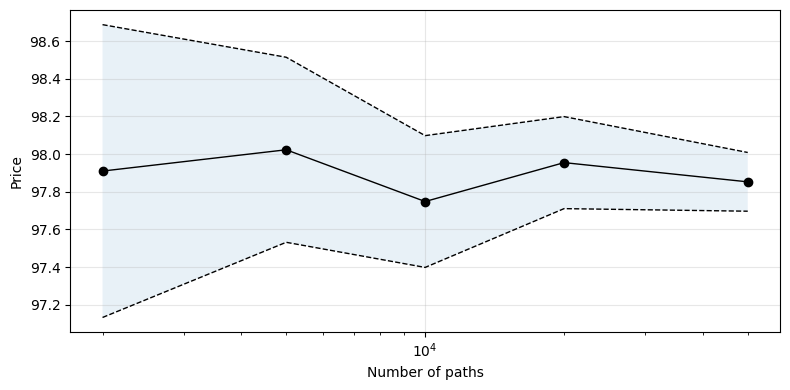

In [ ]:
# --------------------
# Graphe CV MC rapport
# --------------------

# --- grid of MC sizes
n_paths_grid = [2_000, 5_000, 10_000, 20_000, 50_000]

price_grid = []
stderr_grid = []

for n_paths in n_paths_grid:
    price, stats = price_worst_of_autocall_mc(
        model_multi=model_multi,
        T=1.0,
        n_steps=252,
        n_paths=n_paths,
        obs_times=[0.25, 0.50, 0.75, 1.00],
        barrier=0.8,
        coupon=0.06,
        r=0.02,
        nominal=100.0,
        seed=123,
    )
    price_grid.append(price)
    stderr_grid.append(stats["stderr"])

price_grid = np.array(price_grid)
stderr_grid = np.array(stderr_grid)

# --- 95% confidence interval
z = 1.96
lower = price_grid - z * stderr_grid
upper = price_grid + z * stderr_grid

# --- plot (same aesthetic as normalized paths)
plt.figure(figsize=(8, 4))

plt.plot(
    n_paths_grid,
    price_grid,
    color="black",
    linewidth=1,
    marker="o",
)

plt.plot(n_paths_grid, lower, color="black", linestyle="--", linewidth=1)
plt.plot(n_paths_grid, upper, color="black", linestyle="--", linewidth=1)

plt.fill_between(n_paths_grid, lower, upper, alpha=0.10)

plt.xscale("log")
plt.xlabel("Number of paths")
plt.ylabel("Price")

# same grid style
plt.grid(True, alpha=0.3)
plt.tight_layout()
#plt.savefig("/Users/quentinsenes/Desktop/CV_MC.png", dpi=300, bbox_inches="tight")
plt.show()

<a id='2_2'></a>
## 3.2 Sensitivities :

/var/folders/28/1h3z3mcs1gxg23mnjw1zj_n00000gn/T/ipykernel_51440/563655617.py:42: RuntimeWarning: invalid value encountered in scalar divide
  sensi_sigma.append((P_up - P_dn) / (2 * eps))
/var/folders/28/1h3z3mcs1gxg23mnjw1zj_n00000gn/T/ipykernel_51440/563655617.py:52: RuntimeWarning: invalid value encountered in scalar divide
  sensi_rho.append((P_up - P_dn) / (2 * eps))
/var/folders/28/1h3z3mcs1gxg23mnjw1zj_n00000gn/T/ipykernel_51440/563655617.py:62: RuntimeWarning: invalid value encountered in scalar divide
  sensi_r.append((P_up - P_dn) / (2 * eps))
/var/folders/28/1h3z3mcs1gxg23mnjw1zj_n00000gn/T/ipykernel_51440/563655617.py:81: RuntimeWarning: invalid value encountered in scalar divide
  sensi_corr.append((P_up - P_dn) / (2 * eps))


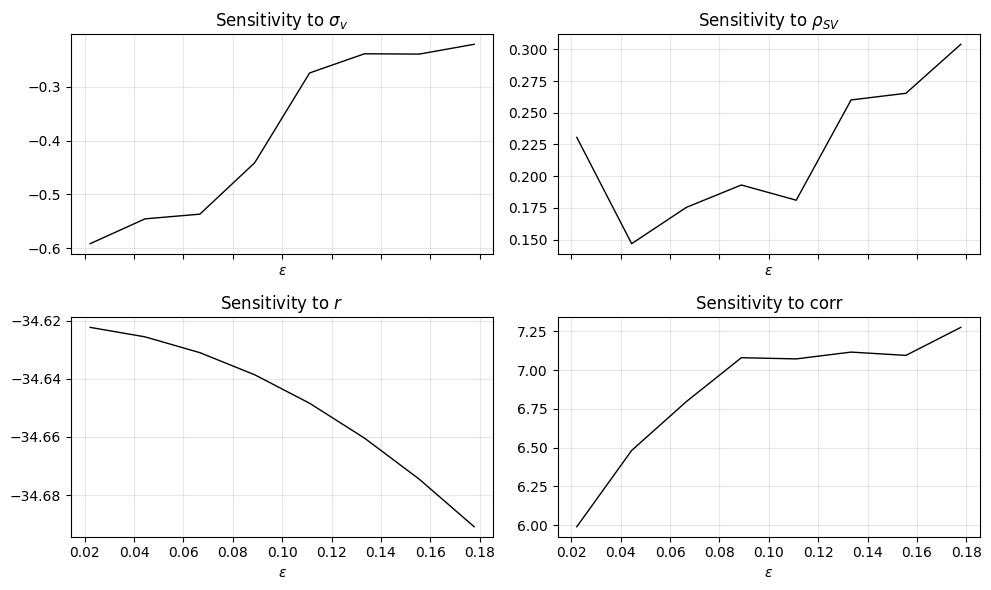

In [77]:
# ---------------------------
# Sensi simples : diff finies
# ---------------------------

price_kwargs = dict(
    T=1.0,
    n_steps=252,
    n_paths=20000,
    obs_times=[0.25, 0.50, 0.75, 1.00],
    barrier=0.8,
    coupon=0.06,
    r=0.02,
    nominal=100.0,
    seed=123,
)

# eps grid (from large to small)
eps_grid = np.linspace(0.2, 0.0, 10)[1:]  # avoid exactly 0

# containers
sensi_sigma = []
sensi_rho   = []
sensi_r     = []
sensi_corr  = []

# choose one asset index for asset-specific params
i_asset = 0

# -----------------------
# Loop on eps
# -----------------------
for eps in eps_grid:

    # --- sigma_v sensitivity
    m_up = copy.deepcopy(model_multi)
    m_dn = copy.deepcopy(model_multi)
    m_up.sigma_v[i_asset] += eps
    m_dn.sigma_v[i_asset] -= eps

    P_up, _ = price_worst_of_autocall_mc(model_multi=m_up, **price_kwargs)
    P_dn, _ = price_worst_of_autocall_mc(model_multi=m_dn, **price_kwargs)
    sensi_sigma.append((P_up - P_dn) / (2 * eps))

    # --- rho (spot/vol) sensitivity
    m_up = copy.deepcopy(model_multi)
    m_dn = copy.deepcopy(model_multi)
    m_up.rho[i_asset] += eps
    m_dn.rho[i_asset] -= eps

    P_up, _ = price_worst_of_autocall_mc(model_multi=m_up, **price_kwargs)
    P_dn, _ = price_worst_of_autocall_mc(model_multi=m_dn, **price_kwargs)
    sensi_rho.append((P_up - P_dn) / (2 * eps))

    # --- rate sensitivity
    r0 = price_kwargs["r"]
    price_kwargs["r"] = r0 + eps
    P_up, _ = price_worst_of_autocall_mc(model_multi=model_multi, **price_kwargs)

    price_kwargs["r"] = r0 - eps
    P_dn, _ = price_worst_of_autocall_mc(model_multi=model_multi, **price_kwargs)

    sensi_r.append((P_up - P_dn) / (2 * eps))
    price_kwargs["r"] = r0  # restore

    # --- correlation sensitivity (uniform off-diagonal bump)
    m_up = copy.deepcopy(model_multi)
    m_dn = copy.deepcopy(model_multi)

    C_up = m_up.corr_matrix_S.copy()
    C_dn = m_dn.corr_matrix_S.copy()
    mask = ~np.eye(C_up.shape[0], dtype=bool)

    C_up[mask] += eps
    C_dn[mask] -= eps

    m_up.corr_matrix_S = C_up
    m_dn.corr_matrix_S = C_dn

    P_up, _ = price_worst_of_autocall_mc(model_multi=m_up, **price_kwargs)
    P_dn, _ = price_worst_of_autocall_mc(model_multi=m_dn, **price_kwargs)
    sensi_corr.append((P_up - P_dn) / (2 * eps))

# convert to arrays
sensi_sigma = np.array(sensi_sigma)
sensi_rho   = np.array(sensi_rho)
sensi_r     = np.array(sensi_r)
sensi_corr  = np.array(sensi_corr)

# -----------------------
# Plot 
# -----------------------
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

axs[0, 0].plot(eps_grid, sensi_sigma, color="black", linewidth=1)
axs[0, 0].set_title(r"Sensitivity to $\sigma_v$")
axs[0, 0].grid(True, alpha=0.3)

axs[0, 1].plot(eps_grid, sensi_rho, color="black", linewidth=1)
axs[0, 1].set_title(r"Sensitivity to $\rho_{SV}$")
axs[0, 1].grid(True, alpha=0.3)

axs[1, 0].plot(eps_grid, sensi_r, color="black", linewidth=1)
axs[1, 0].set_title(r"Sensitivity to $r$")
axs[1, 0].grid(True, alpha=0.3)

axs[1, 1].plot(eps_grid, sensi_corr, color="black", linewidth=1)
axs[1, 1].set_title("Sensitivity to corr")
axs[1, 1].grid(True, alpha=0.3)

for ax in axs.flat:
    ax.set_xlabel(r"$\varepsilon$")

plt.tight_layout()
plt.savefig("/Users/quentinsenes/Desktop/sensi.png", dpi=300, bbox_inches="tight")
plt.show()